In [14]:
# С pandas ранее познакомился на бассейне школы 21 по DataScience,
# так же проходил связаные с темой DS курсы. С pyspark ранее знаком не был.
# на решение через пандас ушло около 12 часов, большую часть времени(минимум 6 часов) решал второй пункт.
# на решения через pyspark ушло часов 6, но 2 пункт(и соответственно 5-ый) решить через pyspark не удалось.
# судя по замеру скорости выполниния программ МОЕ использование pyspark неэффективно

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [15]:
import pandas as pd
import numpy as np

df_panda = pd.read_json("./assignment_data.jsonl", lines=True)

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.functions import desc

spark = SparkSession.builder\
        .master("local[6]")\
        .appName('task1')\
        .getOrCreate()

json_file = './assignment_data.jsonl'
df_spark = spark.read.json(json_file)

In [17]:
from datetime import datetime
import seaborn as sns

In [18]:
import time
def timer(f):
    def tmp(*args, **kwargs):
        t = time.time()
        res = f(*args, **kwargs)
        print ("Время выполнения функции: {}".format(time.time()-t))
        return res

    return tmp

In [19]:
#Сколько сеансов в наборе данных?

In [20]:
@timer
def count_uniq_sessions_panda(df):
    return (df['session_id'].nunique())

@timer
def count_uniq_sessions_spark(df):
    df = df.select('session_id')
    return (df.distinct().count())

print('panda_uniq {}'.format(count_uniq_sessions_panda(df_panda)))
print('spark_uniq {}'.format(count_uniq_sessions_spark(df_spark)))

Время выполнения функции: 0.27842092514038086
panda_uniq 500587


Время выполнения функции: 0.9381229877471924
spark_uniq 500587


In [21]:
#Сколько сеансов завершается в каждой стране? Выведите 10 лучших результатов, отсортированных по
#количеству (DESC) и стране (ASC).

In [22]:
#pandas_only

In [23]:
@timer
def ses_end(df):
    players = df.loc[:, ('player_id', 'country')].drop_duplicates().dropna()
    players = players.set_index('player_id')['country'].to_dict()
    df_end_only = df.loc[df['event'] == 'end']
    df_end_only['country'] = df_end_only['player_id'].map(players)
    df_count_end_country = df_end_only.groupby(['country']).count()
    print(df_count_end_country.sort_values(by=['event', 'country'], ascending=False)['event'].head(10))

ses_end(df_panda)

/Users/pskip/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


country
IT    2839
SH    2672
AZ    2670
AT    2655
WF    2616
VA    2602
HU    2584
IL    2563
RO    2550
KR    2535
Name: event, dtype: int64
Время выполнения функции: 0.9570639133453369


In [24]:
# Сколько сессий завершает каждый игрок? Выведите 10 лучших результатов, отсортированных по
#count(DESC) и player_id(ASC).

In [25]:
@timer
def players_ends_count(df):
    df_end_only = df.loc[df['event'] == 'end']
    df_count_end_players = df_end_only.groupby(['player_id']).count()
    print(df_count_end_players.sort_values(by=['event', 'player_id'], ascending=[False,True])['event'].head(10))

@timer
def players_ends_count_sp(df):
    df_get_player = df.select('player_id', 'event')
    df_get_player = df_get_player.filter(df_get_player['event'] == 'end')
    df_players_end = df_get_player.groupBy('player_id').count()
    df_players_end.sort(col("count").desc(),col("player_id")).show(10)
    
players_ends_count(df_panda)
players_ends_count_sp(df_spark)

player_id
0052e4cfaf494af29d567fcf93057029    50
008c31d6d87d4a72ade8900d4c031f59    50
019f6864a44e4cd1a271db0fc08c7555    50
01d1f31c3c864538a6a5f3cb238d0072    50
0259292bb77e4aaba6782372085990be    50
04318f09e6e7434bb48226f4a8745c21    50
060243602575481db3643bdaacc1146e    50
067b20022f2040b0a0b94efb221e1a6e    50
072d69b007434968966b4c9ddc4e987c    50
08037331842341b2bbfd51d2b12f9049    50
Name: event, dtype: int64
Время выполнения функции: 0.4953339099884033
+--------------------+-----+
|           player_id|count|
+--------------------+-----+
|0052e4cfaf494af29...|   50|
|008c31d6d87d4a72a...|   50|
|019f6864a44e4cd1a...|   50|
|01d1f31c3c864538a...|   50|
|0259292bb77e4aaba...|   50|
|04318f09e6e7434bb...|   50|
|060243602575481db...|   50|
|067b20022f2040b0a...|   50|
|072d69b0074349689...|   50|
|08037331842341b2b...|   50|
+--------------------+-----+
only showing top 10 rows

Время выполнения функции: 0.8985230922698975


In [26]:
#В какой стране в 2016 году было начато наибольшее количество сеансов?

In [27]:
@timer
def count_starts_by_country_pandas(df):
    df_start_only = df[df['event'] == 'start']
    df_start_only_country = df_start_only.groupby(df_start_only['country']).count()
    print(df_start_only_country.sort_values(by = 'event', ascending = False)['event'].head(1))

@timer
def count_starts_by_country_spark(df):
    starts = df.select('country','event').filter(df['event'] == 'start')
    starts = starts.groupby('country').count().sort(col("count").desc()).show(1)

count_starts_by_country_pandas(df_panda)
count_starts_by_country_spark(df_spark)

country
IT    2839
Name: event, dtype: int64
Время выполнения функции: 0.45368194580078125
+-------+-----+
|country|count|
+-------+-----+
|     IT| 2839|
+-------+-----+
only showing top 1 row

Время выполнения функции: 0.5103540420532227


In [28]:
#График завершенных сеансов  по странам. Гистограмма 10 лучших результатов, отсортированных по
#количеству (DESC) и стране (ASC).

/Users/pskip/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Время выполнения функции: 0.8869709968566895


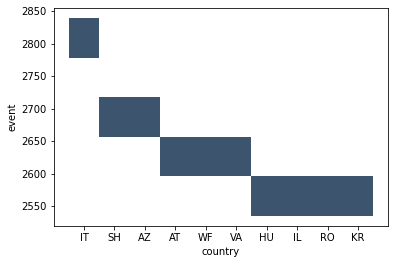

In [31]:
@timer
def ses_end_gist(df):
    players = df[['player_id', 'country']].drop_duplicates().dropna()
    players = players.set_index('player_id')['country'].to_dict()
    df_end_only = df.loc[df['event'] == 'end']
    df_end_only['country'] = df_end_only['player_id'].map(players)
    df_count_end_country = df_end_only.groupby(['country']).count()
    df_for_hist10 = df_count_end_country.sort_values(by=['event', 'country'], ascending=False)['event'][:10]
    sns_10ends = sns.histplot(df_for_hist10, x=df_for_hist10.index, y=df_for_hist10)
    fig = sns_10ends.get_figure()
    
ses_end_gist(df_panda)